<a href="https://colab.research.google.com/github/topister/seq2seq/blob/main/Seq2seq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget http://www.manythings.org/anki/fra-eng.zip


--2024-08-17 04:19:00--  http://www.manythings.org/anki/fra-eng.zip
Resolving www.manythings.org (www.manythings.org)... 173.254.30.110
Connecting to www.manythings.org (www.manythings.org)|173.254.30.110|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7943074 (7.6M) [application/zip]
Saving to: ‘fra-eng.zip’

fra-eng.zip         100%[===================>]   7.57M  6.71MB/s    in 1.1s    

2024-08-17 04:19:01 (6.71 MB/s) - ‘fra-eng.zip’ saved [7943074/7943074]



In [2]:
!unzip fra-eng.zip

Archive:  fra-eng.zip
  inflating: _about.txt              
  inflating: fra.txt                 


In [3]:
import numpy as np
from keras.models import Model
from keras.layers import Input, LSTM, Dense
from keras.utils import plot_model

# Hyperparameters
batch_size = 64   # Batch size for training.
epochs = 10      # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
num_samples = 10000  # Number of samples to train on.

# Path to the data txt file
data_path = 'fra.txt'


In [4]:
# Reading and processing the data
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()

In [5]:
with open(data_path, 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')

In [6]:
for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text, _ = line.split('\t')
    target_text = '\t' + target_text + '\n'
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

In [7]:
input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

In [8]:
input_token_index = dict([(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict([(char, i) for i, char in enumerate(target_characters)])


In [9]:
encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')
decoder_input_data = np.zeros(
    (len(target_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')
decoder_target_data = np.zeros(
    (len(target_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')

In [10]:
for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.
    for t, char in enumerate(target_text):
        decoder_input_data[i, t, target_token_index[char]] = 1.
        if t > 0:
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.


In [11]:
# Define an input sequence and process it.
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

In [12]:
# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, num_decoder_tokens))
# We set up our decoder to return full output sequences, and to return internal states as well.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)


In [13]:
# Define the model that will turn `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)


In [14]:
# Compile the model
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])


In [15]:
# Train the model
model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2)

Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 65s 506ms/step - accuracy: 0.0328 - loss: 1.1359 - val_accuracy: 0.0539 - val_loss: 1.1044
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 48s 380ms/step - accuracy: 0.0447 - loss: 0.9882 - val_accuracy: 0.0515 - val_loss: 1.0824
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 47s 376ms/step - accuracy: 0.0457 - loss: 0.9718 - val_accuracy: 0.0494 - val_loss: 1.0906
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 82s 377ms/step - accuracy: 0.0472 - loss: 0.9583 - val_accuracy: 0.0546 - val_loss: 1.0807
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 81s 376ms/step - accuracy: 0.0504 - loss: 0.9554 - val_accuracy: 0.0603 - val_loss: 1.0810
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 82s 375ms/step - accuracy: 0.0521 - loss: 0.9463 - val_accuracy: 0.0609 - val_loss: 1.0546
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 49s 394ms/step - accuracy: 0.0534 - loss: 0.9423 - val_accuracy: 0.0633 - val_loss: 1.0441
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 47s 376ms/step - accuracy: 0.0555 - loss: 0

In [16]:
# Save the model
model.save('s2s.h5')

In [17]:
# Inference models for testing
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

In [18]:
# Reverse-lookup token index to decode sequences back to characters.
reverse_input_char_index = dict((i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict((i, char) for char, i in target_token_index.items())


In [19]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index['\t']] = 1.

    # Sampling loop for a batch of sequences
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length or find stop character.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    return decoded_sentence



In [20]:
for seq_index in range(10):
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('Decoded sentence:', decoded_sentence)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━

### [Problem 2] Execution of a trained model of image captioning

In [21]:
# !pip install torch torchvision numpy pillow

In [22]:
!git clone https://github.com/pdollar/coco.git
%cd coco/PythonAPI/
!make
!python setup.py build
!python setup.py install
%cd ../../
!git clone https://github.com/yunjey/pytorch-tutorial.git
%cd pytorch-tutorial/tutorials/03-advanced/image_captioning/

Cloning into 'coco'...
remote: Enumerating objects: 975, done.
remote: Total 975 (delta 0), reused 0 (delta 0), pack-reused 975 (from 1)
Receiving objects: 100% (975/975), 11.72 MiB | 24.45 MiB/s, done.
Resolving deltas: 100% (576/576), done.
/content/coco/PythonAPI
python setup.py build_ext --inplace
running build_ext
Compiling pycocotools/_mask.pyx because it changed.
[1/1] Cythonizing pycocotools/_mask.pyx
/usr/local/lib/python3.10/dist-packages/Cython/Compiler/Main.py:381: FutureWarning: Cython directive 'language_level' not set, using '3str' for now (Py3). This has changed from earlier releases! File: /content/coco/PythonAPI/pycocotools/_mask.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
building 'pycocotools._mask' extension
creating build
creating build/common
creating build/temp.linux-x86_64-cpython-310
creating build/temp.linux-x86_64-cpython-310/pycocotools
x86_64-linux-gnu-gcc -Wno-unused-result -Wsign-compare -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-stro

In [23]:
# !python sample.py --image='./data/val2014/COCO_val2014_000000154139.jpg'

In [24]:
!pip install -r requirements.txt
!chmod +x download.sh
!./download.sh

Streaming output truncated to the last 5000 lines.
 extracting: ./data/val2014/COCO_val2014_000000535608.jpg  
 extracting: ./data/val2014/COCO_val2014_000000279145.jpg  
 extracting: ./data/val2014/COCO_val2014_000000243495.jpg  
 extracting: ./data/val2014/COCO_val2014_000000225791.jpg  
 extracting: ./data/val2014/COCO_val2014_000000428067.jpg  
 extracting: ./data/val2014/COCO_val2014_000000059383.jpg  
 extracting: ./data/val2014/COCO_val2014_000000558498.jpg  
 extracting: ./data/val2014/COCO_val2014_000000376123.jpg  
 extracting: ./data/val2014/COCO_val2014_000000191304.jpg  
 extracting: ./data/val2014/COCO_val2014_000000171062.jpg  
 extracting: ./data/val2014/COCO_val2014_000000014549.jpg  
 extracting: ./data/val2014/COCO_val2014_000000121152.jpg  
 extracting: ./data/val2014/COCO_val2014_000000276596.jpg  
 extracting: ./data/val2014/COCO_val2014_000000029431.jpg  
 extracting: ./data/val2014/COCO_val2014_000000036349.jpg  
 extracting: ./data/val2014/COCO_val2014_00000050

In [25]:
!python build_vocab.py
!python resize.py

loading annotations into memory...
Traceback (most recent call last):
  File "/content/pytorch-tutorial/tutorials/03-advanced/image_captioning/build_vocab.py", line 76, in <module>
    main(args)
  File "/content/pytorch-tutorial/tutorials/03-advanced/image_captioning/build_vocab.py", line 58, in main
    vocab = build_vocab(json=args.caption_path, threshold=args.threshold)
  File "/content/pytorch-tutorial/tutorials/03-advanced/image_captioning/build_vocab.py", line 31, in build_vocab
    coco = COCO(json)
  File "/usr/local/lib/python3.10/dist-packages/pycocotools/coco.py", line 81, in __init__
    with open(annotation_file, 'r') as f:
FileNotFoundError: [Errno 2] No such file or directory: 'data/annotations/captions_train2014.json'
/content/pytorch-tutorial/tutorials/03-advanced/image_captioning/resize.py:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  return image.resize(size, Image.ANTIALIAS

In [26]:
!unzip "/content/drive/MyDrive/DIVIC/data/pretrained_model.zip"

Archive:  /content/drive/MyDrive/DIVIC/data/pretrained_model.zip
  inflating: encoder-5-3000.pkl      
  inflating: decoder-5-3000.pkl      


In [33]:
!python train.py

Namespace(model_path='models/', crop_size=224, vocab_path='data/vocab.pkl', image_dir='data/resized2014', caption_path='data/annotations/captions_train2014.json', log_step=10, save_step=1000, embed_size=256, hidden_size=512, num_layers=1, num_epochs=5, batch_size=128, num_workers=2, learning_rate=0.001)
loading annotations into memory...
Done (t=1.46s)
creating index...
index created!
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnin

In [28]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [35]:
!python sample.py --image='png/example.png'

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
<start> a group of giraffes standing next to each other . <end>


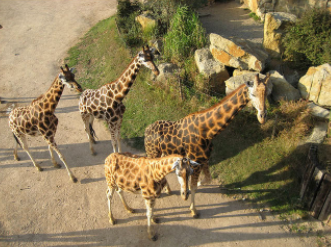

In [37]:
from PIL import Image
Image.open('./png/example.png')

### [Problem 3] Investigate what to do if you want to move with Keras

To move a model from PyTorch to Keras, the process begins by converting the PyTorch implementation to Keras, which can be achieved using conversion tools or by manually reconstructing the model architecture in Keras. A converter available in the project's README can facilitate this process, enabling the transfer of the model's architecture and weights to Keras. Once the Keras model is obtained, it can be saved as an H5 file. This H5 file can then be converted into a TensorFlow.js model using the tensorflowjs_converter tool, which transforms the Keras model into a format suitable for web applications.

After the conversion to a TensorFlow.js model, the final step involves setting up the model for use in a web environment. The converted model files, including the .pb file for the model structure and the weights_manifest.json for the model's weights, are then loaded in the web application using TensorFlow.js. The following code snippet demonstrates how to load the converted model:

```
const MODEL_URL = 'model_tfjs/tensorflowjs_model.pb'
const WEIGHTS_URL = 'model_tfjs/weights_manifest.json'
const model = await tf.loadFrozenModel(MODEL_URL, WEIGHTS_URL)
```

### [Problem 4] (Advance assignment) Code reading and rewriting

To rewrite the given PyTorch model in Keras, we will break down the EncoderCNN and DecoderRNN classes and implement their equivalents using Keras layers.

#### EncoderCNN (keras implementation)
The EncoderCNN uses a pre-trained ResNet-152 model to extract features from images, then passes these features through a fully connected layer and a batch normalization layer. In Keras, we can use the ResNet152 model available in keras.applications.

```
from tensorflow.keras.applications import ResNet152
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras import Input

def build_encoder(embed_size):
    # Load the pre-trained ResNet-152 model, excluding the top layers (fully connected layers)
    resnet = ResNet152(weights='imagenet', include_top=False)
    
    # Add a fully connected layer and a batch normalization layer
    x = Flatten()(resnet.output)
    x = Dense(embed_size)(x)
    x = BatchNormalization(momentum=0.01)(x)
    
    # Create the encoder model
    model = Model(resnet.input, x)
    
    return model
```

#### DecoderRNN (keras implementation)
The DecoderRNN class uses an embedding layer, an LSTM layer, and a fully connected layer to generate captions. We'll implement this using Keras's Embedding, LSTM, and Dense layers.

```
from tensorflow.keras.layers import Embedding, LSTM, Dense, Concatenate
from tensorflow.keras.models import Model

def build_decoder(embed_size, hidden_size, vocab_size, num_layers, max_seq_length=20):
    # Define the input layers
    features_input = Input(shape=(embed_size,))
    captions_input = Input(shape=(max_seq_length,))
    
    # Embedding layer
    embeddings = Embedding(vocab_size, embed_size)(captions_input)
    
    # Concatenate image features with the embeddings
    features = Dense(embed_size)(features_input)
    features = BatchNormalization(momentum=0.01)(features)
    features = Reshape((1, embed_size))(features)
    embeddings = Concatenate(axis=1)([features, embeddings])
    
    # LSTM layers
    lstm = LSTM(hidden_size, return_sequences=True, return_state=False)(embeddings)
    for _ in range(num_layers - 1):
        lstm = LSTM(hidden_size, return_sequences=True, return_state=False)(lstm)
    
    # Fully connected layer to predict the next word in the sequence
    outputs = Dense(vocab_size, activation='softmax')(lstm)
    
    # Create the decoder model
    model = Model(inputs=[features_input, captions_input], outputs=outputs)
    
    return model
```

#### Discussion of the keras implementation
1. EncoderCNN

We load the ResNet152 model with include_top=False to exclude the fully connected layers.

The output of ResNet152 is passed through a Flatten layer to convert the feature maps into a 1D vector, followed by a Dense layer to reduce the dimensionality to the desired embedding size.

Finally, a BatchNormalization layer is added to normalize the output.

2. DecoderRNN

The decoder starts with an Embedding layer to convert word indices into dense vectors.

The image features are passed through a Dense layer and reshaped to match the LSTM's input requirements.

The image features are concatenated with the word embeddings, and this concatenated sequence is passed through an LSTM layer. If there are multiple LSTM layers, they are stacked sequentially.

The output of the LSTM is passed through a Dense layer with a softmax activation to predict the next word in the sequence.


### [Problem 5] (Advance assignment) Developmental survey

1. Translating between Japanese and English using the implementation of Problem 1

To translate between Japanese and English using the Seq2Seq implementation from Problem 1, several adjustments are necessary. First, the need to create a dataset containing parallel sentences in Japanese and English. Preprocessing the dataset is crucial, including tokenization, padding, and creating vocabularies for both languages. Japanese requires specific tokenization due to its complex script, and libraries like MeCab or SpaCy can assist in this process. Once preprocessing is done, the Seq2Seq model should be trained on this new dataset. Also since I already have a pre-trained model for English-to-French translation, i can fine-tune it on the Japanese-English dataset, which might help in achieving better performance with fewer resources.

2. Advanced methods of machine translation

Machine translation has significantly evolved with the advent of deep learning. The Transformer model, introduced by Vaswani et al. in 2017, revolutionized the field by enabling parallel processing of sentences and capturing long-range dependencies more effectively than RNNs and LSTMs.

Transformers are the backbone of many state-of-the-art models like OpenAI's GPT, Google's BERT, and Facebook's mBART. Additionally, large-scale pre-trained models like OpenAI's GPT-4 and Google's mT5 can perform translation tasks effectively by leveraging vast amounts of multilingual data. Fine-tuning these models on specific language pairs can yield superior results compared to traditional Seq2Seq models.

3. Generating images from text

Text-to-image generation is a fascinating area of research in deep learning, where models are trained to generate images based on textual descriptions. One of the most well-known models in this domain is DALL·E, developed by OpenAI, which can create detailed images from natural language prompts. Another popular model is VQ-VAE-2 combined with Transformers, which generates high-quality images by learning a discrete latent representation of images. Recently, diffusion models like Stable Diffusion have gained popularity due to their ability to produce high-resolution and coherent images from text. These models often involve a two-step process where text is first encoded into a latent space and then decoded into an image, making them highly versatile and powerful tools for text-to-image generation.